In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import time
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def create_new_experiment_dir(exp_base_dir):
    def get_unique_name(): return time.strftime("%Y%m%d-%H%M%S")

    exp_base_dir = os.path.abspath(os.path.expanduser(exp_base_dir))
    if exp_base_dir[-1] != '/':
        exp_base_dir += '/'

    # Create new experiment directory
    exp_dir = exp_base_dir + get_unique_name() + '/'
    os.makedirs(exp_dir)

    os.makedirs(exp_dir + 'pickle_dump/')
    os.makedirs(exp_dir + 'logs/')

    return exp_dir

In [4]:
data_df = pd.read_csv('/home/zunaira/Downloads/DDOS_CleanDataset/CICFlowData_clean.csv')
feat = list(data_df.columns)
#feat.remove('flow_id')
feat.remove('label')
print (feat)

['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes', 'flow_packets', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packets', 'bwd_packets', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'cwe_flag_count', 'ece_flag_count', 'down

In [5]:
data_df.sample(10)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
313830,80,996,5,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
100841,80,85105272,6,5,371,11595,371,0,61.833333,151.460116,...,32,986.0,0.0,986,986,85000000.0,0.0,85000000,85000000,DoS Hulk
437811,53,59263916,2,2,90,122,47,43,45.000000,2.828427,...,20,282952.0,0.0,282952,282952,59000000.0,0.0,59000000,59000000,BENIGN
540553,53,48757,2,2,68,132,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
629957,53,31524,2,2,78,214,39,39,39.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
563061,53,320,2,2,88,188,44,44,44.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
205950,52164,3,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
306501,53,212,2,2,76,180,38,38,38.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
81313,80,153657,3,7,371,11595,371,0,123.666667,214.196950,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
156604,80,98896332,7,6,375,11595,375,0,53.571429,141.736677,...,32,979.0,0.0,979,979,98900000.0,0.0,98900000,98900000,DoS Hulk


In [17]:
feat = filter(lambda x: x not in ['source_port', 'destination_port', 'protocol'], feat)


In [21]:
print (list(feat))

['flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes', 'flow_packets', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packets', 'bwd_packets', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'cwe_flag_count', 'ece_flag_count', 'down_up_ratio', 'average

In [7]:
data_df.label.unique()

array(['BENIGN', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye'], dtype=object)

In [8]:
labels = {'BENIGN': 0, 'DoS slowloris': 1, 'DoS Slowhttptest': 2, 'DoS Hulk': 3,
       'DoS GoldenEye': 4}
classes = len(labels.keys())
for k, v in labels.items():
   data_df.loc[data_df.label == k, 'enclabel'] = v

In [9]:
print ('Data Label counts:')
class_weights = {}
for k, v in labels.items():
    count = (data_df.enclabel == v).sum()
    p = (count / float(data_df.shape[0])) * 100
    class_weights[v] = p
    print (('%s flows count: %d  Percentage: %.2f%%') % (k, count, p))
comp_cls_wt = compute_class_weight(
    'balanced', data_df.enclabel.unique(), data_df.enclabel)
display(comp_cls_wt)

Data Label counts:
BENIGN flows count: 439683  Percentage: 63.59%
DoS slowloris flows count: 5796  Percentage: 0.84%
DoS Slowhttptest flows count: 5499  Percentage: 0.80%
DoS Hulk flows count: 230124  Percentage: 33.28%
DoS GoldenEye flows count: 10293  Percentage: 1.49%


array([ 0.31449704, 23.85766046, 25.1462084 ,  0.60088909, 13.43427572])

In [10]:
from sklearn.model_selection import train_test_split

In [22]:
X = data_df[feat].values
y = data_df['enclabel'].values

In [53]:
#splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(
   X, y, train_size=0.8, test_size=0.2,stratify=y)

In [54]:
# Splitting Train Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.8,test_size=0.2, stratify=y_train)

In [55]:
print (f'Train data: {X_train.shape}')
print (f'Train labels:{y_train.shape}')
print (f'Validation data:{X_val.shape}')
print (f'Validation labels:{y_val.shape}')
print (f'Test data: {X_test.shape}')
print (f'Test labels {y_test.shape}')

Train data: (442492, 76)
Train labels:(442492,)
Validation data:(110624, 76)
Validation labels:(110624,)
Test data: (138279, 76)
Test labels (138279,)


In [56]:
td= (y_train == v).sum()
vd= (y_val == v).sum()
tstd= (y_test == v).sum()

print ("Training data:")
for k, v in labels.items():
    print ("%s flows count:%s" % (k,td))


#print ('/n',"Validation data:")
#for k, v in labels.items():
#print ("%s flows count:%s" % (k,vd))
 

#print ("Testing data:")
#for k, v in labels.items():
 #   print ("%s flows count:%s" % (k,tstd))


Training data:
BENIGN flows count:6587
DoS slowloris flows count:6587
DoS Slowhttptest flows count:6587
DoS Hulk flows count:6587
DoS GoldenEye flows count:6587


In [57]:
B_perc= (data_df['enclabel'] == labels['BENIGN']).sum() / float(data_df.shape[0]) * 100
print (f'Benign flows: {(B_perc)}%')
Atck_perc= ((data_df['enclabel'] != labels['BENIGN']).sum() / float(data_df.shape[0]) * 100)
print (f'Attack flows: {Atck_perc}%') 

Benign flows: 63.59360423491637%
Attack flows: 36.40639576508364%


In [58]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [48]:
#Create a Gaussian Classifier
clf_tst=RandomForestClassifier(n_estimators=100)

#Train the model using the test sets y_pred=clf.predict(X_test)
clf_tst.fit(X_test,y_test)

y_pred_tstData=clf_tst.predict(X_test)

In [39]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9990092494160357


In [49]:
#Accuracy [test_data]
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tstData))

Accuracy: 0.999956609463476


In [47]:
#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
 #           max_depth=None, max_features='auto', max_leaf_nodes=None,
  #          min_impurity_decrease=0.0, min_impurity_split=None,
   #         min_samples_leaf=1, min_samples_split=2,
    #        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
     #       oob_score=False, random_state=None, verbose=0,
      #      warm_start=False)

In [42]:
feature_imp = pd.Series(clf.feature_importances_,index=feat).sort_values(ascending=False)
feature_imp

bwd_packet_length_std          0.111795
bwd_packet_length_mean         0.075837
packet_length_mean             0.047966
bwd_packets                    0.047453
average_packet_size            0.047267
bwd_packet_length_max          0.044673
init_win_bytes_forward         0.043336
avg_bwd_segment_size           0.040478
packet_length_std              0.037504
subflow_bwd_bytes              0.028715
max_packet_length              0.024705
fwd_packet_length_mean         0.020927
packet_length_variance         0.019967
flow_bytes                     0.019635
fwd_packets                    0.019127
fwd_packet_length_max          0.018526
idle_max                       0.017333
flow_iat_mean                  0.017130
subflow_bwd_packets            0.017076
total_length_of_bwd_packets    0.016875
subflow_fwd_bytes              0.016301
fwd_iat_max                    0.016070
avg_fwd_segment_size           0.014659
flow_iat_std                   0.013837
idle_min                       0.013797


In [45]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 853kB/s ta 0:00:01


No handles with labels found to put in legend.


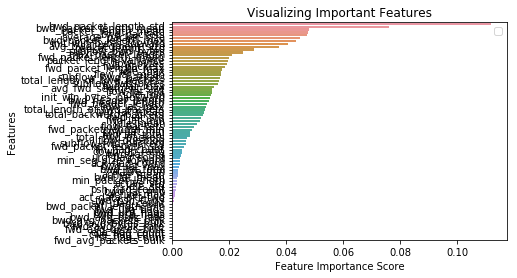

In [46]:
import seaborn as sns

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()